In [12]:
import csv
import cv2
import sys
import pickle
import random
import numpy as np

import os
import json

import matplotlib.pyplot as plt

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, ELU
from sklearn.preprocessing import LabelBinarizer

from sklearn.utils import shuffle

In [13]:
print("module imported")

module imported


In [14]:
#ch, row, col = 3, 160, 320
channels, rows, columns = 3, 66, 200  # camera format

Images mapped with 13425 examples


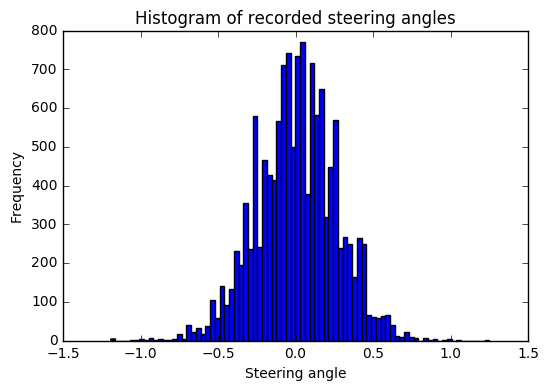

In [65]:
#Below code is not useful anymore
list_images = []

# The following value is added and subtracted from the steering angle for the images of the right and left side of the car
offset = 0.25

import random
bias = 0.5

#center_images, labels = [],[]
with open('data/driving_log.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    next(reader)
    for row in reader:
        steering = float(row['steering'].strip())
        #print(steering)

        steering_thresh = np.random.rand()
        if (abs(steering) + bias) < steering_thresh:
            pass # drop this sample
        else:
            if (steering == 0):
                if (np.random.rand() > 0.85): #0.7 # 0.65
                    # Center image
                    center_images.append(row['center'].strip()) 
                    # Left image
                    center_images.append(row['left'].strip())
                    # Right image
                    center_images.append(row['right'].strip())
                    labels.append(steering)
                    labels.append(steering+offset)
                    labels.append(steering-offset)
                    
                    #TODO: more data augmentation
                    center_images.append(row['center'].strip()) 
                    labels.append(steering+0.05)
                    center_images.append(row['center'].strip()) 
                    labels.append(steering-0.05)
                    
            else:
                # Center image
                center_images.append(row['center'].strip()) 
                # Left image
                center_images.append(row['left'].strip())
                # Right image
                center_images.append(row['right'].strip())
                labels.append(steering)
                labels.append(steering+offset)
                labels.append(steering-offset)
                
                #TODO: more data augmentation
                center_images.append(row['center'].strip()) 
                labels.append(steering+0.05)
                center_images.append(row['center'].strip()) 
                labels.append(steering-0.05)
        
print('Images mapped with {} examples'.format(len(center_images)))

import matplotlib.pyplot as plt
%matplotlib inline

#histogram = [x[1] for x in list_images]

plt.hist(labels, bins = 80, facecolor='blue');
plt.xlabel('Steering angle');
plt.ylabel('Frequency');
plt.title('Histogram of recorded steering angles');


In [15]:
#Fetch data from pickle file
with open('data/driving_data.p', mode='rb') as f:
    driving_data = pickle.load(f)

center_images = driving_data['center_images']
left_images = driving_data['left_images']
right_images = driving_data['right_images']
labels = driving_data['labels']

#shuffle a dataset
#images, labels = shuffle(center_images, labels)

# split train & valid data
X_train, X_validation, y_train, y_validation = train_test_split(center_images, labels, test_size=0.1, random_state=42)

print(type(center_images))
#print(X_train[0].shape)
print(len(X_train))
print(len(X_validation))


<class 'list'>
7232
804


In [16]:
# define functions
def augment_brightness(image):
	"""
	apply random brightness on the image
	"""
	image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
	random_bright = .25+np.random.uniform()
	
	# scaling up or down the V channel of HSV
	image[:,:,2] = image[:,:,2]*random_bright
	return image

def trans_image(image,steer,trans_range, trans_y=False):
	"""
	translate image and compensate for the translation on the steering angle
	"""
	
	rows, cols, chan = image.shape
	
	# horizontal translation with 0.008 steering compensation per pixel
	tr_x = trans_range*np.random.uniform()-trans_range/2
	steer_ang = steer + tr_x/trans_range*.4
	
	# option to disable vertical translation (vertical translation not necessary)
	if trans_y:
		tr_y = 40*np.random.uniform()-40/2
	else:
		tr_y = 0
	
	Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
	image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
	
	return image_tr,steer_ang


def crop_image(image, y1, y2, x1, x2):
	"""
	crop image into respective size
	give: the crop extent
	"""
	return image[y1:y2, x1:x2]


def im_process(image, steer_ang, train=True):
    """
    Apply processing to image
    """    
    # image size
    im_y = image.shape[0]
    im_x = image.shape[1]
    
    # translate image and compensate for steering angle
    trans_range = 50
    image, steer_ang = trans_image(image, steer_ang, trans_range) # , trans_y=True
    
    # crop image region of interest
    image = crop_image(image, 20, 140, 0+trans_range, im_x-trans_range)
    
    # flip image (randomly)
    if np.random.uniform()>= 0.5: #and abs(steer_ang) > 0.1
        image = cv2.flip(image, 1)
        steer_ang = -steer_ang
    
    # augment brightness
    image = augment_brightness(image)
    
    # perturb steering with a bias
    # steer_ang += np.random.normal(loc=0,scale=0.2)
    
    # image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    
    return image, steer_ang

In [58]:

#custom rows and columns to fit Nvidia model
custom_rows, custom_cols = 66, 200

#path="data/"
path = ""
def get_image(center_images, left_images, right_images, labels, index, image_offset=0.25):
    
    camera = np.random.choice(['center', 'left', 'right'])

    if camera == 'center':
        image, steering = plt.imread('data/'+center_images[index]), float(labels[index])
    elif camera == 'left':
        image, steering = plt.imread('data/'+left_images[index]), float(labels[index])+image_offset
    elif camera == 'right':
        image, steering = plt.imread('data/'+right_images[index]), float(labels[index])-image_offset

    image, steering = plt.imread('data/'+center_images[index]), float(labels[index])
    
    #Augment image 
    image, angle = augment_image(image, steering)
    #image, angle = im_process(image, steering)
    
    image = cv2.resize(image, (custom_cols, custom_rows))
    image = np.reshape(image, (1, custom_rows, custom_cols, channels))
    return image, steering

def flip_image(image, angle):
    if random.randint(0, 1):
        return cv2.flip(image, 1), -angle
    else:
        return image, angle

def rotate_image(image, angle):
    rows,cols,channel = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(-5, 5), 1)
    return cv2.warpAffine(image,M,(cols,rows)), angle

def brightness_image(image, steering):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = hsv[:,:,2] * random.uniform(0.3, 1.2)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), steering

def cut_image(img):
    rows,cols,channel = img.shape
    top = int(.4 * rows)
    botton = int(.85 * rows)
    border = int(.05 * cols)
    return img[top:botton, border:cols-border, :]

#translate image and compensate for the translation on the steering angle
def translate_image(img, steering, horz_range=30, vert_range=5):
    rows, cols, chs = img.shape
    tx = np.random.randint(-horz_range, horz_range+1)
    ty = np.random.randint(-vert_range, vert_range+1)
    steering = steering + tx * 0.004 # mul by steering angle units per pixel
    tr_M = np.float32([[1,0,tx], [0,1,ty]])
    img = cv2.warpAffine(img, tr_M, (cols,rows), borderMode=1)
    return img, steering

def augment_image(image, angle):
    
    #Rotate image
    #image, angle = rotate_image(image,angle)
    
    #Crop image
    
    #Translate image - required
    image, steering = translate_image(np.copy(image), angle)
    
    #Flip image - required
    image, angle = flip_image(np.copy(image),angle)
    
    #Brightness
    #image, angle = brightness_image(np.copy(image),angle)
    
    #cut image - required
    image = cut_image(image)
    
    image = (image - 128.0) / 128.0
    
    return image, angle

#Generator, and training
def my_generator(center_images, left_images, right_images, labels, batch_size):
    batch_train = np.zeros((batch_size, rows, columns, 3))
    batch_angle = np.zeros(batch_size)
    while True:
        for index in range(batch_size):
            image, angle = get_image(center_images, left_images, right_images, labels, index)
            batch_train[i], batch_angle[i] = image, angle
        yield batch_train, batch_angle
 

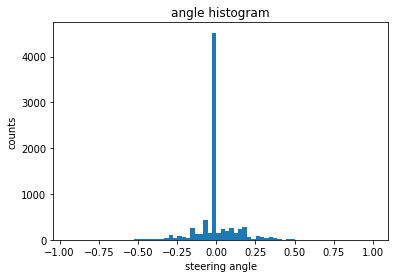

In [59]:
# histogram of labels count

plt.hist(labels, bins=70)
plt.title('angle histogram')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()


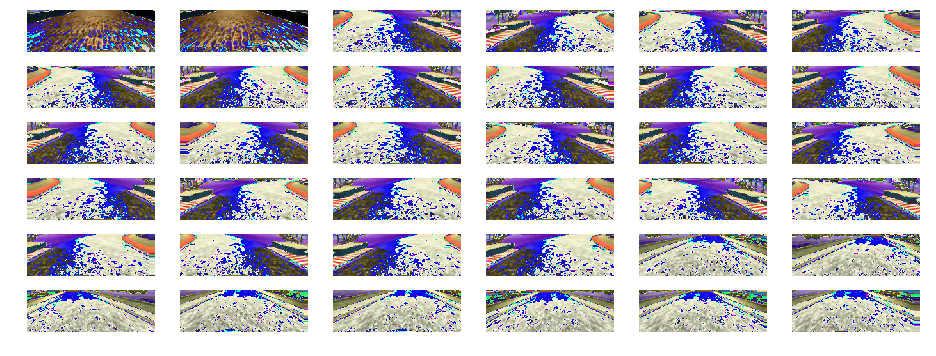

In [60]:
#Randomly print few images
plt.figure(figsize=(16,6))
for i in range(36):
    #random_index = np.random.randint(0,len(center_images))
    image,angle = get_image(center_images, left_images, right_images, labels, i)
    #image,angle = get_image1(center_images, labels, i)
    plt.subplot(6,6,i+1)
    plt.imshow(image.squeeze(), cmap="gray");
    plt.axis('off')
plt.show()

In [61]:
def commaai_model(time_len=1):

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Convolution2D(16, 8, 8, input_shape=(3,160,320), subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    return model

def nvidia_model(time_len=1):
    ch, row, col = 3, 66, 200  # camera format
    INIT='glorot_uniform' # 'he_normal', glorot_uniform
    keep_prob = 0.2
    reg_val = 0.01
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    # W_regularizer=l2(reg_val)
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Flatten())

    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(10))
    model.add(ELU())
    
    model.add(Dense(1))

    #model.compile(optimizer="adam", loss="mse") # , metrics=['accuracy']
    
    return model


In [62]:
batch_size = 64
EPOCHS = 10

model = nvidia_model()

#print model summary
#model.summary()

# Compile model using Adam optimizer
# and loss computed by mean squared error
model.compile(loss='mean_squared_error',
              optimizer=Adam(),
              metrics=['accuracy'], 
              validation_data=(X_validation, y_validation), 
              verbose=1)

my_generator = my_generator(center_images, left_images, right_images, labels, batch_size)
#my_generator = my_generator1(center_images, labels, batch_size)

# Model training
# TODO: Add validation data
history = model.fit_generator(
    my_generator,
    samples_per_epoch=batch_size*(int((len(center_images)/batch_size))-1), # of training samples
    nb_epoch=EPOCHS,
    verbose=1
)

print("model training complete")

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1917: UserWarning: Expected no kwargs, you passed 2
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/10
7936/7936 [==============================] - 29s - loss: 0.0318 - acc: 0.9802      

In [64]:
#Save the model
model_json = 'model.json'
model_weights = 'model.h5'

json_string = model.to_json()
try:
    os.remove(model_json)
    os.remove(model_weights)
except OSError:
    pass

with open(model_json, 'w') as jfile:
    json.dump(json_string, jfile)
model.save(model_weights)

print("model saved")

model saved
